In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders
!pip install graphviz
!pip install -q dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd

import matplotlib.pyplot as plt  

import numpy as np
import category_encoders as ce 
import _pickle as pkl 

from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from joblib import dump,load 

from sklearn.tree import export_text
from sklearn import preprocessing
from sklearn import tree

from IPython.display import SVG, display

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Das Einladen der Daten

> Input Data: 

> *   unit_mapping.csv
> *   datatype_mapping.csv
> *   train.csv
> *   queries.csv
> *   corpus.csv






In [4]:
root = '/content/drive/MyDrive/Colab/NLP/BA_Jo/fusioniertes Modell/fusioniertes Modell alter Datensatz/' 

rm_quote = lambda x: x.replace('"', '')

unit_mapping = pd.read_csv(root + 'unit_mapping.csv',sep=",", quoting=0)
datatype_mapping = pd.read_csv(root + 'datatype_mapping.csv',sep=";", quoting=3, converters={'\"datatype':rm_quote,'datatype_categ\"':rm_quote}).rename(columns=rm_quote)
data_train= pd.read_csv(root + 'train.csv',sep=";", quoting=3, converters={'\"aas_spec':rm_quote,'metalabel\"':rm_quote}).rename(columns=rm_quote)
data_corp= pd.read_csv(root + 'corpus.csv',sep=";", quoting=3, converters={'\"did':rm_quote, 'metalabel\"':rm_quote}).rename(columns=rm_quote)
data_test= pd.read_csv(root + 'queries.csv',sep=";", quoting=3, converters={'\"did':rm_quote, 'metalabel\"':rm_quote}).rename(columns=rm_quote)


In [5]:
#Show Data: UnitMapping
unit_mapping.head()


,Unit,unit_categ
0,NaN,NaN
1,Hertz,FREQUENCY
2,Hz,FREQUENCY
3,Pa,PRESSURE
4,Pascal,PRESSURE


In [6]:
#Show Data: DTMapping
datatype_mapping.head()


,datatype,datatype_categ
0,BOOLEAN,BOOLEAN
1,STRING,STRING
2,TRANSLATABLE_STRING,STRING
3,NON_TRANSLATABLE_STRING,STRING
4,DATE,DATE


In the first step of preprocessing, the corpus data (data_corp) and the query data (data_test) are prepared by mapping the specified units and data types to the appropriate supercategory Unit_Categ or Datatype_Categ, which can be processed in the decision tree. 

Then, missing values are filled with placeholders so that the algorithm does not automatically delete or arbitrarily fill the submodel elements with missing values in individual categories.

In the third and fourth step, the metalabels and features are encoded.


## Mapping of Unit und Datatype

In [7]:
data_corp['unit_categ']=np.random.randint(1, 6, data_corp.shape[0]).astype('object')
for i in range (len(data_corp)):
    valueUnit= data_corp.loc[i,'unit']
    g=unit_mapping[unit_mapping['Unit'] == valueUnit]
    glist=g['unit_categ'].values.tolist()
    data_corp.at[i,'unit_categ']= glist

data_corp['unit_categ']=(data_corp['unit_categ'].apply(lambda x: pd.Series(x))
                 .stack()
                 .reset_index(level=1, drop=True)
                 .to_frame('unit_categ'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [8]:
data_test['unit_categ']=np.random.randint(1, 6, data_test.shape[0]).astype('object') 
for i in range (len(data_test)):
    valueUnit= data_test.loc[i,'unit']
    g=unit_mapping[unit_mapping['Unit'] == valueUnit]
    glist=g['unit_categ'].values.tolist()
    data_test.at[i,'unit_categ']= glist

data_test['unit_categ']=(data_test['unit_categ'].apply(lambda x: pd.Series(x))
                 .stack()
                 .reset_index(level=1, drop=True)
                 .to_frame('unit_categ'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


### Mapping of Datatype

In [9]:
data_corp['datatype_categ']=np.random.randint(1, 6, data_corp.shape[0]).astype('object') 
for i in range (len(data_corp)):
    valuedt= data_corp.loc[i,'datatype']
    g=datatype_mapping[datatype_mapping['datatype'] == valuedt]
    glist=g['datatype_categ'].values.tolist()
    data_corp.at[i,'datatype_categ']= glist

data_corp['datatype_categ']=(data_corp['datatype_categ'].apply(lambda x: pd.Series(x))
                 .stack()
                 .reset_index(level=1, drop=True)
                 .to_frame('datatype_categ'))
#Queries:
data_test['datatype_categ']=np.random.randint(1, 6, data_test.shape[0]).astype('object') 
for i in range (len(data_test)):
    valuedt= data_test.loc[i,'datatype']
    g=datatype_mapping[datatype_mapping['datatype'] == valuedt]
    glist=g['datatype_categ'].values.tolist()
    data_test.at[i,'datatype_categ']= glist

data_test['datatype_categ']=(data_test['datatype_categ'].apply(lambda x: pd.Series(x))
                 .stack()
                 .reset_index(level=1, drop=True)
                 .to_frame('datatype_categ'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [10]:
data_train_filled=data_train.fillna("missing")
data_corp_filled=data_corp.fillna("missing")
data_test_filled=data_test.fillna("missing") 

## Visualization

In [11]:
data_train_filled['metalabel']= data_train_filled['metalabel'].str.split('|')
data_corp_filled['metalabel']= data_corp_filled['metalabel'].str.split('|')
data_test_filled['metalabel']= data_test_filled['metalabel'].str.split('|')

data_corp_filled.head() 

,did,query,name,aas_spec,qualifier,category,datatype,unit,metalabel,unit_categ,datatype_categ
0,1,Bar code number that identifies the device bas...,GTIN code,Property,SUP,Constant,STRING,missing,[50],missing,STRING
1,2,Alphanumeric character sequence identifying a ...,Article number,Property,SUP,Constant,STRING,missing,[50],missing,STRING
2,3,"13-digit numeric code, identifying all 'standa...",National stock number,Property,SUP,Constant,STRING,missing,[50],missing,STRING
3,4,Unique combination of numbers and letters used...,Code of product,Property,SUP,Constant,STRING,missing,[50],missing,STRING
4,5,Unique combination of numbers and letters used...,Order code of product,Property,SUP,Constant,STRING,missing,[50],missing,STRING


In [12]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

classes = to_1D(data_train_filled['metalabel']).unique().tolist() 
classes_corp = to_1D(data_corp_filled['metalabel']).unique().tolist()
classes_test = to_1D(data_test_filled['metalabel']).unique().tolist() 

print("Vorhandene Labelklassen Trainingsdaten:",classes)
print("Vorhandene Labelklassen Corpusdaten:",classes_corp)
print("Vorhandene Labelklassen Testdaten:",classes_test)


Vorhandene Labelklassen Trainingsdaten: ['1', '2', '3', '29', '4', '58', '5', '30', '6', '63', '7', '31', '8', '62', '9', '32', '10', '33', '11', '59', '12', '35', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '34', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '60', '61', '65', '68', '69', '70', '71', '72', '73', '74', '75', '76', '79', '81', '83']
Vorhandene Labelklassen Corpusdaten: ['50', '45', '46', '44', '39', '41', '40', '43', '38', '37', '51', '2', '48', '49', '42', '47', '52', '36', '33', '34', '32', '30', '31', '35', '7', '4', '9', '5', '11', '8', '10', '6', '12', '25', '23', '20', '1', '24', '26', '28', '3', '29', '16', '19', '22', '15', '17', '18', '14', '27', '13', '21', '70', '53', '54', '55', '72', '56', '68', '57', '58', '59', '60', '61', '62', '71', '83', '63', '79', '76', '73', '81', '65', '74', '69', '75']
Vorhandene Labelklassen Tes

Text(0.5, 1.0, 'metalabel_train')

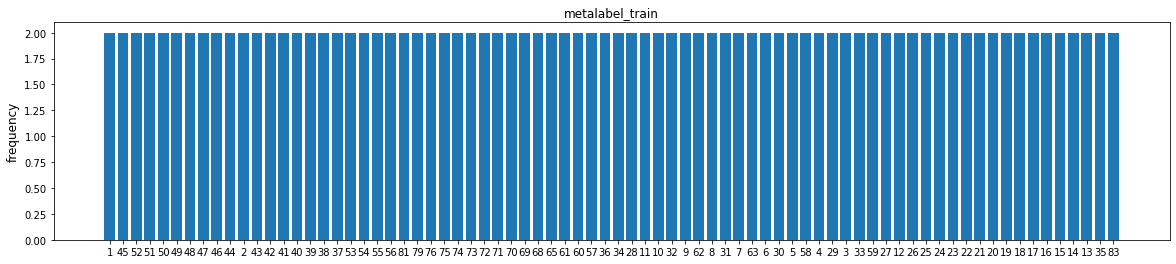

In [13]:
fig, ax = plt.subplots(figsize = (20,4))

ax.bar(to_1D(data_train_filled['metalabel']).value_counts().index, 
       to_1D(data_train_filled['metalabel']).value_counts().values) 
ax.set_ylabel("frequency", size = 12) 
ax.set_title("metalabel_train", size =12) 

Text(0.5, 1.0, 'metalabel_corp')

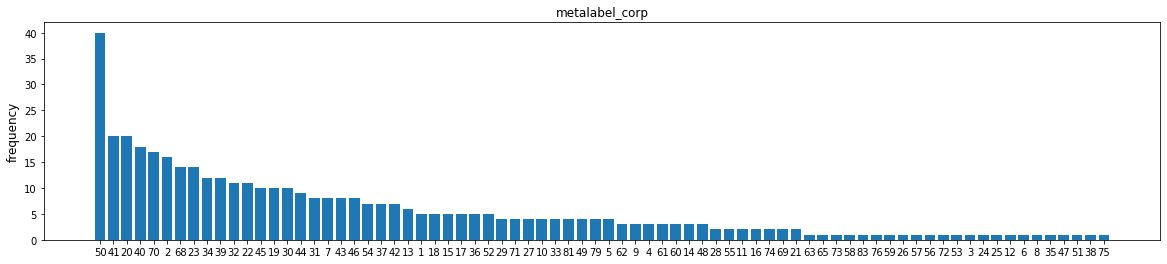

In [14]:
fig, ax = plt.subplots(figsize = (20,4))
ax.bar(to_1D(data_corp_filled['metalabel']).value_counts().index,
       to_1D(data_corp_filled['metalabel']).value_counts().values)
ax.set_ylabel("frequency", size = 12)
ax.set_title("metalabel_corp", size =12)

Text(0.5, 1.0, 'metalabel_test')

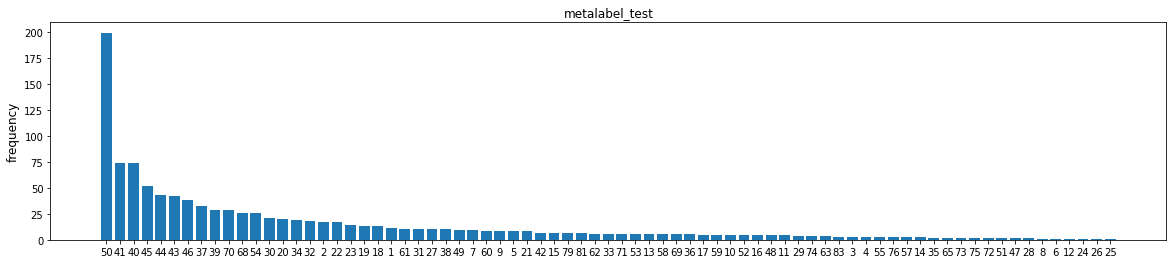

In [15]:
fig, ax = plt.subplots(figsize = (20,4))
ax.bar(to_1D(data_test_filled['metalabel']).value_counts().index,
       to_1D(data_test_filled['metalabel']).value_counts().values)
ax.set_ylabel("frequency", size = 12)
ax.set_title("metalabel_test", size =12)

### Encoden

In [16]:
print(data_train_filled.dtypes) 

aas_spec          object
qualifier         object
category          object
unit_categ        object
datatype_categ    object
metalabel         object
dtype: object


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=classes).fit(data_train_filled['metalabel']) 
metalabel_train_enc = mlb.transform (data_train_filled['metalabel']) 
metalabel_corp_enc = mlb.transform (data_corp_filled['metalabel']) 
metalabel_test_enc = mlb.transform (data_test_filled['metalabel'])

print(metalabel_train_enc) 
print(type(metalabel_train_enc)) 

[[1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
<class 'numpy.ndarray'>


In [18]:
#numpy do dataframe

metalabel_train= pd.DataFrame(metalabel_train_enc, columns=classes) 
metalabel_corp= pd.DataFrame(metalabel_corp_enc, columns=classes) 
metalabel_test= pd.DataFrame(metalabel_test_enc, columns=classes) 

print(metalabel_test.head()) 
     

   1  2  3  29  4  58  5  30  6  63  ...  70  71  72  73  74  75  76  79  81  \
0  0  0  0   0  0   0  0   0  0   0  ...   0   0   0   0   0   0   0   0   0   
1  0  0  0   0  0   0  0   0  0   0  ...   0   0   0   0   0   0   0   0   0   
2  0  0  0   0  0   0  0   0  0   0  ...   0   0   0   0   0   0   0   0   0   
3  0  0  0   0  0   0  0   0  0   0  ...   0   0   0   0   0   0   0   0   0   
4  0  0  0   0  0   0  0   0  0   0  ...   0   0   0   0   0   0   0   0   0   

   83  
0   0  
1   0  
2   0  
3   0  
4   0  

[5 rows x 76 columns]


## Metadata categories


In [19]:
feature_cols=['aas_spec','category','qualifier','unit_categ','datatype_categ'] 

df_features_train = data_train_filled[feature_cols]
df_features_corp = data_corp_filled[feature_cols]
df_features_test = data_test_filled[feature_cols] 

#Encoding:
encoder = ce.OrdinalEncoder(cols=feature_cols, return_df=True).fit (df_features_train)

features_train = encoder.transform(df_features_train) 
features_corp = encoder.transform(df_features_corp)
features_test = encoder.transform(df_features_test)

#Speichern:
dump(encoder, open('encoder.pkl', 'wb')) 



# Decision Tree

In [20]:
x_train=features_train 
y_train= metalabel_train 
x_corp=features_corp
y_corp=metalabel_corp
x_test=features_test 
y_test= metalabel_test 


In [21]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion ='gini', splitter='best')

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict train data for checking accuracy of model
y_pred_train = clf.predict(x_train)
y_pred_train

dump(clf, 'decisionTree.joblib')

#Predict the response for corpus dataset
y_pred_corp = clf.predict(x_corp)
print("Label Predictions Corpusset binär:", y_pred_corp)

#Predict the response for test dataset
y_pred = clf.predict(x_test)
print("Label Predictions Testset binär:", y_pred)


Label Predictions Corpusset binär: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Label Predictions Testset binär: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
#Corpus Daten:
y_pred_corp_inv =mlb.inverse_transform(y_pred_corp)
print ("Label Predictions Corpusset kategorisch:", y_pred_corp_inv)
#Test Daten:
y_pred_inv =mlb.inverse_transform(y_pred)
print ("Label Predictions Testset kategorisch:", y_pred_inv)


Label Predictions Corpusset kategorisch: [('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('45',), ('45',), ('46',), ('46',), ('44',), ('39',), ('41',), ('41',), ('40',), ('43',), ('43',), ('38',), ('44',), ('44',), ('41',), ('40',), ('40',), ('41',), ('43',), ('37',), ('37',), ('37',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('51',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('50',), ('2',), ('50',), ('50',), ('50',), ('46',), ('46',), ('48',), ('48',), ('40',), ('40',), ('40',), ('40',), ('40',), ('40',), ('44',), ('44',), ('44',), ('44',), ('44',), ('39',), ('49',), ('39',), ('39',), ('39',), ('39',), ('39',), ('39',), ('41',), ('41',), ('41',), ('41',), ('2',), ('2',), ('2',), ('2',), ('2',), ('42',), ('42',), ('42',), ('42',), ('47',), ('52',), ('52',), ('48',), ('52',), ('36',), ('36',), (

In [23]:
print("Training accuracy score:", metrics.accuracy_score(y_train, y_pred_train))
print("Corpus accuracy score:", metrics.accuracy_score(y_corp, y_pred_corp))
print("Test accuracy score:", metrics.accuracy_score(y_test, y_pred))



Training accuracy score: 1.0
Corpus accuracy score: 1.0
Test accuracy score: 1.0


# Corpus Creation

In [24]:
ind = x_corp.index 
lst = y_pred_corp_inv 
x = pd.Series(lst, index = ind)

labeled_corpus = pd.concat([x_corp, x], axis=1)
labeled_corpus.rename(columns = {0:'metalabel'}, inplace = True)

print('Dataframe Corpus ("labeled_corpus"):\n', labeled_corpus)




Dataframe Corpus ("labeled_corpus"):
      aas_spec  category  qualifier  unit_categ  datatype_categ metalabel
0           2         4          3           1               7     (50,)
1           2         4          3           1               7     (50,)
2           2         4          3           1               7     (50,)
3           2         4          3           1               7     (50,)
4           2         4          3           1               7     (50,)
..        ...       ...        ...         ...             ...       ...
422         2         3          6           1               3     (68,)
423         2         3          6           1               3     (68,)
424         2         2          1           3               3     (15,)
425         2         2          1           3               3     (15,)
426         3         1          3           1               4     (75,)

[427 rows x 6 columns]


In [25]:
labeled_corpus=pd.DataFrame(data=labeled_corpus)

In [26]:
import pandas as pd
labeled_corpus.to_excel("labeled_corpus.xlsx", sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True, freeze_panes=None)

In [27]:
pred_corpus_id=[0, 10, 2, 5, 6, 7, 8, 9, 10, 14, 15, 4, 3, 16, 0, 0, 0, 0, 0, 0, 15, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 7, 8, 8, 6, 8, 6, 9, 9, 10, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 29, 21, 21, 29, 21, 21, 21, 22, 22, 22, 22, 22, 298, 22, 298, 22, 22, 21, 21, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 337, 337, 25, 337, 25, 337, 337, 337, 337, 25, 337, 337, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 33, 36, 38, 36, 36, 37, 37, 38, 38, 34, 34, 35, 35, 7, 6, 14, 39, 8, 8, 41, 41, 44, 44, 43, 43, 44, 44, 45, 44, 45, 44, 47, 48, 48, 48, 49, 49, 50, 50, 51, 51, 52, 54, 53, 53, 55, 55, 57, 57, 59, 60, 61, 62, 62, 63, 64, 19, 65, 20, 66, 66, 67, 67, 68, 69, 69, 70, 71, 72, 73, 72, 73, 74, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 87, 88, 31, 90, 95, 92, 93, 94, 97, 97, 98, 99, 100, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 155, 158, 159, 160, 161, 162, 163, 164, 162, 166, 167, 170, 169, 170, 171, 169, 169, 174, 175, 176, 177, 179, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 170, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 237, 238, 239, 240, 242, 247, 244, 245, 246, 243, 248, 249, 250, 250, 250, 27, 26, 27, 27, 252, 252, 252, 253, 253, 253, 255, 255, 255, 337, 256, 256, 257, 257, 257, 257, 85, 86, 257, 258, 250, 331, 259, 250, 259, 260, 260, 260, 208, 208, 208, 208, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 328, 264, 264, 264, 264, 264, 264, 266, 266, 266, 266, 266, 268, 268, 268, 268, 268, 269, 268, 268, 269, 269, 269, 269, 256, 272, 272, 269, 272, 272, 272, 272, 272, 272, 259, 259, 259, 274, 274, 275, 275, 276, 276, 276, 276, 276, 276, 277, 277, 278, 278, 278, 19, 19, 19, 19, 20, 20, 20, 281, 282, 282, 283, 284, 285, 286, 286, 288, 288, 289, 289, 290, 290, 293, 294, 294, 295, 295, 297, 297, 299, 299, 299, 235, 234, 301, 303, 303, 303, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 152, 306, 307, 308, 307, 308, 308, 308, 309, 310, 310, 310, 311, 311, 312, 312, 312, 313, 313, 313, 314, 313, 315, 315, 316, 316, 317, 317, 317, 317, 318, 318, 319, 319, 319, 319, 320, 320, 320, 321, 321, 321, 321, 321, 321, 328, 328, 323, 352, 324, 324, 324, 325, 325, 325, 326, 326, 327, 328, 328, 329, 329, 329, 329, 344, 330, 330, 330, 331, 331, 331, 331, 331, 332, 333, 334, 334, 334, 335, 33, 32, 32, 32, 336, 336, 25, 337, 25, 25, 25, 338, 338, 338, 338, 339, 339, 340, 340, 340, 341, 341, 342, 342, 343, 343, 344, 344, 345, 345, 346, 346, 346, 347, 347, 347, 347, 348, 348, 348, 350, 350, 351, 351, 351, 351, 353, 353, 354, 354, 260, 352, 356, 357, 357, 359, 359, 360, 360, 361, 362, 363, 363, 364, 365, 365, 365, 365, 365, 366, 366, 366, 367, 367, 368, 369, 370, 371, 371, 372, 373, 373, 374, 374, 375, 375, 376, 376, 118, 117, 378, 378, 378, 379, 379, 389, 383, 383, 382, 382, 387, 386, 386, 389, 389, 388, 388, 390, 390, 391, 391, 392, 392, 392, 392, 392, 392, 364, 364, 396, 395, 396, 397, 397, 399, 399, 400, 400, 401, 401, 401, 402, 402, 402, 403, 403, 404, 404, 405, 406, 407, 408, 408, 409, 409, 410, 411, 411, 412, 412, 414, 413, 413, 422, 414, 422, 415, 420, 417, 420, 418, 418, 419, 420, 420, 421, 421, 422, 423, 423, 424, 425, 424, 425, 426, 426]


pred_corpus_id=pd.DataFrame(data=pred_corpus_id)
pred_corpus_id.to_excel("pred_corpus_id.xlsx", sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True, freeze_panes=None)

In [28]:
#store corpus:
labeled_corpus.to_pickle(root+"MetadataCorpus.pkl")


# Mapping 

In [29]:
ind = x_test.index 
lst = y_pred_inv 
x = pd.Series(lst, index = ind) 

labeled_queries = pd.concat([x_test, x], axis=1)
labeled_queries.rename(columns = {0:'metalabel'}, inplace = True)

print('Dataframe Queries ("labeled_queries"):\n', labeled_queries)

Dataframe Queries ("labeled_queries"):
       aas_spec  category  qualifier  unit_categ  datatype_categ metalabel
0            2         4          3           1               7     (50,)
1            2         4          3           1               7     (50,)
2            2         4          3           1               7     (50,)
3            2         4          3           1               7     (50,)
4            2         4          3           1               7     (50,)
...        ...       ...        ...         ...             ...       ...
1047         2         2          2           3               3     (15,)
1048         2         2          1           3               3     (15,)
1049         2         2          1           3               3     (15,)
1050         3         1          3           1               4     (75,)
1051         3         1          3           1               4     (75,)

[1052 rows x 6 columns]


In [30]:
corpus=pd.read_pickle(root+"MetadataCorpus.pkl")
print('Dataframe Corpus ("corpus"):\n', corpus)

Dataframe Corpus ("corpus"):
      aas_spec  category  qualifier  unit_categ  datatype_categ metalabel
0           2         4          3           1               7     (50,)
1           2         4          3           1               7     (50,)
2           2         4          3           1               7     (50,)
3           2         4          3           1               7     (50,)
4           2         4          3           1               7     (50,)
..        ...       ...        ...         ...             ...       ...
422         2         3          6           1               3     (68,)
423         2         3          6           1               3     (68,)
424         2         2          1           3               3     (15,)
425         2         2          1           3               3     (15,)
426         3         1          3           1               4     (75,)

[427 rows x 6 columns]


In [31]:
corpus_label=pd.DataFrame(corpus['metalabel'].tolist(), index=corpus.index).rename(columns={0:"label_corpus"})
print(corpus_label)

queries_label=pd.DataFrame(labeled_queries['metalabel'].tolist(), index= labeled_queries.index).rename(columns={0: "label_query1", 1:"label_query2"})
print(queries_label)

    label_corpus
0             50
1             50
2             50
3             50
4             50
..           ...
422           68
423           68
424           15
425           15
426           75

[427 rows x 1 columns]
     label_query1 label_query2
0              50         None
1              50         None
2              50         None
3              50         None
4              50         None
...           ...          ...
1047           15         None
1048           15         None
1049           15         None
1050           75         None
1051           75         None

[1052 rows x 2 columns]


In [32]:
queries_label['indices_corpus']=np.random.randint(1, 6, queries_label.shape[0]).astype('object')
for i in range (len(queries_label)):
    value1= queries_label.loc[i,'label_query1']
    value2= queries_label.loc[i,'label_query2']  
    g=corpus_label.index[corpus_label['label_corpus'] == value1] 
    h=corpus_label.index[corpus_label['label_corpus'] == value2]
    glist=g.values.tolist()
    hlist=h.values.tolist()
    listall=glist+hlist
    queries_label.at[i,'indices_corpus']= listall

print(queries_label)

     label_query1 label_query2  \
0              50         None   
1              50         None   
2              50         None   
3              50         None   
4              50         None   
...           ...          ...   
1047           15         None   
1048           15         None   
1049           15         None   
1050           75         None   
1051           75         None   

                                         indices_corpus  
0     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
2     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
3     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
4     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
...                                                 ...  
1047                          [221, 244, 249, 424, 425]  
1048                          [221, 244, 249, 424, 425]  
1049                          [221, 244, 249, 424, 425]  
1050       

# Sentence BERT

In [33]:
queries_label['index'] = queries_label.index

In [34]:
queries_label.head()

,label_query1,label_query2,indices_corpus,index
0,50,None,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0
1,50,None,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1
2,50,None,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2
3,50,None,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3
4,50,None,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4


In [35]:
queries_label.shape

(1052, 4)

In [36]:
data_corpus= pd.read_csv(root + 'corpus_pump_rlt_submodels.csv',sep=";", quoting=3, converters={'\"did':rm_quote, 'MetaLabel\"':rm_quote})
data_corpus.head()

,did,question,name
0,1,Bar code number that identifies the device bas...,GTIN code
1,2,Alphanumeric character sequence identifying a ...,Article number
2,3,"13-digit numeric code, identifying all 'standa...",National stock number
3,4,Unique combination of numbers and letters used...,Code of product
4,5,Unique combination of numbers and letters used...,Order code of product


In [37]:
print(data_corpus.shape)

(427, 3)


In [38]:
data_corpus.head()

,did,question,name
0,1,Bar code number that identifies the device bas...,GTIN code
1,2,Alphanumeric character sequence identifying a ...,Article number
2,3,"13-digit numeric code, identifying all 'standa...",National stock number
3,4,Unique combination of numbers and letters used...,Code of product
4,5,Unique combination of numbers and letters used...,Order code of product


In [39]:
data_corpus['index'] = data_corpus.index

In [40]:
data_corpus.head()

,did,question,name,index
0,1,Bar code number that identifies the device bas...,GTIN code,0
1,2,Alphanumeric character sequence identifying a ...,Article number,1
2,3,"13-digit numeric code, identifying all 'standa...",National stock number,2
3,4,Unique combination of numbers and letters used...,Code of product,3
4,5,Unique combination of numbers and letters used...,Order code of product,4


In [41]:
data_test.head()

,did,query,name,duplicate_ids,aas_spec,qualifier,category,datatype,unit,metalabel,unit_categ,datatype_categ
0,18,internationally unique and unambiguous article...,GTIN,1,Property,SUP,Constant,STRING,NaN,50,NaN,STRING
1,19,unique product identifier of the manufacturer,Article number,2,Property,SUP,Constant,STRING,NaN,50,NaN,STRING
2,20,"13-digit numeric code, identifying all the sta...",National stock number,3,Property,SUP,Constant,STRING,NaN,50,NaN,STRING
3,21,Characteristic to differentiate between differ...,Product type,6,Property,SUP,Constant,STRING,NaN,50,NaN,STRING
4,22,Short description of the product (short text),Product name,7,Property,SUP,Constant,STRING,NaN,50,NaN,STRING


In [42]:
data_test['duplicate_ids']-=1

In [43]:
data_test['index'] = data_test.index

In [44]:
data_test.head()

,did,query,name,duplicate_ids,aas_spec,qualifier,category,datatype,unit,metalabel,unit_categ,datatype_categ,index
0,18,internationally unique and unambiguous article...,GTIN,0,Property,SUP,Constant,STRING,NaN,50,NaN,STRING,0
1,19,unique product identifier of the manufacturer,Article number,1,Property,SUP,Constant,STRING,NaN,50,NaN,STRING,1
2,20,"13-digit numeric code, identifying all the sta...",National stock number,2,Property,SUP,Constant,STRING,NaN,50,NaN,STRING,2
3,21,Characteristic to differentiate between differ...,Product type,5,Property,SUP,Constant,STRING,NaN,50,NaN,STRING,3
4,22,Short description of the product (short text),Product name,6,Property,SUP,Constant,STRING,NaN,50,NaN,STRING,4


In [45]:
import string

class DocumentPreparation:

  def prepareDocuments(dataset_query, dataset_corpus, meta_classes):
      print(type(dataset_query))

      ir_needed_dids_eval = set()      

      query_definitions = list()
      corpus_names = list()
      corpus_definitions = list()

      ir_queries_eval = dict(zip(dataset_query['index'], dataset_query['query']))    
      ir_query_names_eval = dict(zip(dataset_query['index'], dataset_query['name']))  
      ir_relevant_docs_eval = dict(zip(dataset_query['index'], dataset_query['duplicate_ids'])) 
      ir_corpus_eval = dict(zip(dataset_corpus['index'], dataset_corpus['question']))
      ir_corpus_names_eval = dict(zip(dataset_corpus['index'], dataset_corpus['name']))
      true_corpus_id = list(dataset_query['duplicate_ids'])

      query_names = list(dataset_query['name'])
      query_definitions = list(dataset_query['query'])
      corpus_names = list(dataset_corpus['name'])
      corpus_definitions = list(dataset_corpus['question'])

      meta_classes = dict(zip(meta_classes['index'], meta_classes['indices_corpus']))
      
      return ir_queries_eval, ir_query_names_eval, ir_needed_dids_eval, ir_corpus_eval, ir_corpus_names_eval, ir_relevant_docs_eval, query_names, query_definitions, corpus_names, corpus_definitions, meta_classes, true_corpus_id

In [46]:
ir_queries_eval, ir_query_names_eval, ir_needed_dids_eval, ir_corpus_eval, ir_corpus_names_eval, ir_relevant_docs_eval, query_names, query_definitions, corpus_names, corpus_definitions, meta_classes, true_corpus_id = DocumentPreparation.prepareDocuments(dataset_query= data_test, dataset_corpus= data_corpus, meta_classes = queries_label)

<class 'pandas.core.frame.DataFrame'>


In [47]:
print("Dictionarys: For Information Retrieval")

print("corpus")
print("ir_corpus_eval:", ir_corpus_eval)
print("ir_corpus_names_eval:", ir_corpus_names_eval)

print("queries")
print("ir_queries_eval:", ir_queries_eval)
#print(type(ir_queries_eval))
print("ir_query_names_eval:", ir_query_names_eval)
#print(type(ir_query_names_eval))
print("ir_needed_dids_eval:", ir_needed_dids_eval)


Dictionarys: For Information Retrieval
corpus
ir_corpus_eval: {0: 'Bar code number that identifies the device based on the Global Trade Item Number system', 1: 'Alphanumeric character sequence identifying a manufactured, non-configurable product', 2: "13-digit numeric code, identifying all 'standardized material items of supply' as recognized by the United States Department of Defense", 3: 'Unique combination of numbers and letters used to identify the device', 4: 'Unique combination of numbers and letters used to order the device', 5: 'Characterization of the device based on its usage, operation principle, and its fabricated form', 6: 'Short description of the product (short text)', 7: 'Name of the supplier or vendor of a device', 8: 'legally valid designation of the natural or judicial person which is directly responsible for the design, production, packaging and labeling of a product in respect to its being brought into circulation', 9: 'Alphanumeric character sequence assigned to a

In [48]:
print("corpus")
print("corpus_definitions:", corpus_definitions)
print("corpus_names:", corpus_names)

print("queries")
print("query_definitions:", query_definitions)
print("query_names:", query_names)

print("duplicate ids")
print("true_corpus_id:", true_corpus_id)

print("Metadata Label")
print("meta_classes:", meta_classes)

corpus
corpus_definitions: ['Bar code number that identifies the device based on the Global Trade Item Number system', 'Alphanumeric character sequence identifying a manufactured, non-configurable product', "13-digit numeric code, identifying all 'standardized material items of supply' as recognized by the United States Department of Defense", 'Unique combination of numbers and letters used to identify the device', 'Unique combination of numbers and letters used to order the device', 'Characterization of the device based on its usage, operation principle, and its fabricated form', 'Short description of the product (short text)', 'Name of the supplier or vendor of a device', 'legally valid designation of the natural or judicial person which is directly responsible for the design, production, packaging and labeling of a product in respect to its being brought into circulation', 'Alphanumeric character sequence assigned to a fabricated product, which allows the date, time and circumstance

In [49]:
!pip install -U sentence-transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from sentence_transformers import losses, util
from sentence_transformers import SentencesDataset, LoggingHandler, SentenceTransformer, evaluation, models
from sentence_transformers.readers import InputExample
from sentence_transformers import CrossEncoder
from sentence_transformers.util import batch_to_device, pytorch_cos_sim
from typing import List, Tuple, Dict, Set
import logging
from torch import nn
import torch

In [51]:
# DistilBERT Model
model = SentenceTransformer('mboth/distil-eng-quora-sentence')

In [52]:
class OwnInformationRetrievalEvaluator:


    def __init__(self,
                 meta_classes: Dict[int, Set[int]],
                 queries: Dict[str, str],  #qid => query
                 query_names: Dict[str, str],
                 corpus: Dict[str, str],  #cid => doc
                 corpus_names: Dict[str, str],
                 relevant_docs: Dict[str, Set[str]],  #qid => Set[cid]
                 show_progress_bar: bool = False,
                 batch_size: int = 32,
                 name: str = ''):
      
        self.queries_ids = []
        for qid in queries:
            if qid in relevant_docs:
                self.queries_ids.append(qid)

        self.queries = [queries[qid] for qid in self.queries_ids]

        self.query_names = [query_names[qid] for qid in self.queries_ids]

        self.corpus_ids = list(corpus.keys())

        self.corpus = [corpus[cid] for cid in self.corpus_ids]

        self.corpus_names = [corpus_names[cid] for cid in self.corpus_ids]

        self.relevant_docs = relevant_docs
        self.show_progress_bar = show_progress_bar
        self.batch_size = batch_size
        self.name = name
        self.meta_classes = meta_classes
        self.true_corpus_id = true_corpus_id

        if name:
            name = "_" + name

        self.csv_file: str = "Information-Retrieval_evaluation" + name + "_results.csv"
        self.csv_headers = ["epoch", "steps"]


    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        if epoch != -1:
            out_txt = " after epoch {}:".format(epoch) if steps == -1 else " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logging.info("Information Retrieval Evaluation on " + self.name + " dataset" + out_txt)

        query_embeddings = model.encode(self.queries, show_progress_bar=self.show_progress_bar, batch_size=self.batch_size, convert_to_tensor=True)
        query_name_embeddings = model.encode(self.query_names, show_progress_bar=self.show_progress_bar, batch_size=self.batch_size, convert_to_tensor=True)
        concat_name_def_query_emb = torch.cat((query_name_embeddings, query_embeddings), 1)
        corpus_embeddings = model.encode(self.corpus, show_progress_bar=self.show_progress_bar, batch_size=self.batch_size, convert_to_tensor=True)
        corpus_name_embeddings = model.encode(self.corpus_names, show_progress_bar=self.show_progress_bar, batch_size=self.batch_size, convert_to_tensor=True)
        concat_name_def_corpus_emb = torch.cat((corpus_name_embeddings, corpus_embeddings), 1)

        cos_values = []
        predicted_corpus = []

        for key in self.meta_classes:
          print('key: '+ str(key))
          corpus_meta = self.meta_classes[key]
          print('corpus meta:' + str(corpus_meta))

          meta_list = []
          for item in corpus_meta:                            
            one_corpus_emb = concat_name_def_corpus_emb[int(item)]
            meta_list.append(one_corpus_emb) 
          
          stack_tensor = torch.stack(meta_list, dim = 0)      
          cos_score = pytorch_cos_sim(concat_name_def_query_emb[int(key)], stack_tensor)

          cos_value, cos_index = torch.max(cos_score,1)
          cos_values.append(cos_value)

          identified_corpus = corpus_meta[cos_index]

          predicted_corpus.append(identified_corpus)
        print(cos_values)
        print(predicted_corpus)

        accuracy = metrics.accuracy_score(self.true_corpus_id, predicted_corpus) 
        print(self.true_corpus_id)
        print('Accuracy: '+ str(accuracy)) 

        precision_recall = metrics.precision_recall_fscore_support(self.true_corpus_id, predicted_corpus, average= 'micro')
        print(precision_recall)

        return predicted_corpus

In [53]:
evaluator_no_pool = OwnInformationRetrievalEvaluator(meta_classes, ir_queries_eval, ir_query_names_eval, ir_corpus_eval,ir_corpus_names_eval ,ir_relevant_docs_eval, true_corpus_id)

In [54]:
predicted_corpus = model.evaluate(evaluator_no_pool)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

key: 0
corpus meta:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63]
key: 1
corpus meta:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63]
key: 2
corpus meta:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63]
key: 3
corpus meta:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63]
key: 4
corpus meta:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63]
key: 5
corpus meta:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 